In [50]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin


class SimpleAutoBucketer(BaseEstimator, TransformerMixin):
    """
    AutoBucketer that creates KMeans clusters for features.
    Handles all data types by using KMeans on encoded values.
    
    Parameters:
    -----------
    n_buckets : int, default=5
        Maximum number of buckets to create for each feature
    random_state : int, default=42
        Random seed for reproducibility
    passthrough : bool, default=False
        If True, skip KMeans bucketing and use the encoded values directly
    """
    
    def __init__(self, n_buckets=5, random_state=42, passthrough=False):
        self.n_buckets = n_buckets
        self.random_state = random_state
        self.passthrough = passthrough
        self.encoders = {}
        self.models = {}
        self.feature_names = None
    
    def _encode_values(self, values, encoder=None):
        """Helper method to encode feature values"""
        if encoder is None:
            # For numeric features
            try:
                encoded_values = values.astype(float)
                return encoded_values.reshape(-1, 1), None
            except (ValueError, TypeError):
                # If conversion fails, treat as categorical
                pass
                
        # For categorical features
        str_values = np.array([str(v) for v in values])
        
        if encoder is None:
            # Create a new encoder
            unique_values, encoded_values = np.unique(str_values, return_inverse=True)
            encoder = dict(zip(unique_values, range(len(unique_values))))
        else:
            # Use existing encoder
            encoded_values = np.array([encoder.get(v, -1) for v in str_values])
            # Replace -1 with a valid value to avoid errors
            if -1 in encoded_values:
                encoded_values[encoded_values == -1] = 0
                
        return encoded_values.reshape(-1, 1), encoder
    
    def fit(self, X, y=None, X_val=None, y_val=None):
        """
        Fit the bucketing model on the data
        
        Parameters:
        -----------
        X : array-like or DataFrame
            Training data
        y : array-like, default=None
            Target values (not used)
        X_val : array-like or DataFrame, default=None
            Validation data for scoring models. If None, X will be used.
        y_val : array-like, default=None
            Validation targets (not used)
        """
        # Use X for validation if X_val is not provided
        if X_val is None:
            X_val = X
        
        # Store feature names
        if hasattr(X, 'columns'):
            self.feature_names = X.columns.tolist()
        else:
            self.feature_names = [f'feature_{i}' for i in range(X.shape[1])]
        
        # Process each feature
        for j, col_name in enumerate(self.feature_names):
            # Extract the feature values
            if hasattr(X, 'iloc'):
                train_values = X.iloc[:, j].values
                val_values = X_val.iloc[:, j].values
            else:
                train_values = X[:, j]
                val_values = X_val[:, j]
            
            # Encode training values
            train_encoded, encoder = self._encode_values(train_values)
            self.encoders[col_name] = encoder
            
            # Encode validation values
            val_encoded, _ = self._encode_values(val_values, encoder)
            
            # If passthrough is True, mark this feature for passthrough
            if self.passthrough:
                self.models[col_name] = "passthrough"
                continue
            
            # Try different numbers of buckets and score on validation set
            scores = []
            fitted_models = []
            
            for nb in range(2, self.n_buckets):
                n_buckets = min(nb, len(np.unique(train_encoded)))
                
                if n_buckets < 2:
                    # If only one unique value, no need for bucketing
                    continue
                
                # Fit KMeans on training data
                kmeans = KMeans(
                    n_clusters=n_buckets,
                    random_state=self.random_state,
                    n_init=10
                )
                kmeans.fit(train_encoded)
                
                # Score on validation data
                val_score = kmeans.score(val_encoded)
                scores.append(val_score)
                fitted_models.append(kmeans)
            
            if not scores:
                # If no valid models were fitted
                self.models[col_name] = None
                continue
            
            # Select the best number of buckets based on validation score
            best_idx = np.argmax(scores)
            best_nb = list(range(2, self.n_buckets))[best_idx]
            
            # Combine train and validation data for final fit
            if hasattr(X, 'iloc'):
                combined_values = np.concatenate([train_values, val_values])
            else:
                combined_values = np.concatenate([train_values, val_values])
            
            combined_encoded, _ = self._encode_values(combined_values, encoder)
            
            # Fit final model on combined data
            n_buckets = min(best_nb, len(np.unique(combined_encoded)))
            
            if n_buckets < 2:
                # If only one unique value, no need for bucketing
                self.models[col_name] = None
            else:
                # Fit KMeans on combined data
                kmeans = KMeans(
                    n_clusters=n_buckets,
                    random_state=self.random_state,
                    n_init=10
                )
                kmeans.fit(combined_encoded)
                self.models[col_name] = kmeans
        
        return self
    
    def transform(self, X):
        """Transform the data into bucket assignments"""
        # Create output array
        bucket_array = np.zeros((X.shape[0], len(self.feature_names)))
        
        # Process each feature
        for j, col_name in enumerate(self.feature_names):
            # Extract the feature values
            if hasattr(X, 'iloc'):
                values = X.iloc[:, j].values
            else:
                values = X[:, j]
            
            # Get the encoder and model
            encoder = self.encoders[col_name]
            model = self.models[col_name]
            
            # Encode the values
            encoded_values, _ = self._encode_values(values, encoder)
            
            # Handle different model cases
            if model == "passthrough":
                # Use encoded values directly
                bucket_array[:, j] = encoded_values.flatten()
                continue
            elif model is None:
                # If no model, just use zeros
                bucket_array[:, j] = 0
                continue
            
            # Predict bucket assignments
            try:
                bucket_array[:, j] = model.predict(encoded_values)
            except:
                # If prediction fails, use zeros
                bucket_array[:, j] = 0
        
        return bucket_array
    
    def fit_transform(self, X, y=None, X_val=None, y_val=None):
        """
        Fit the model and transform the data in one step
        
        Parameters:
        -----------
        X : array-like or DataFrame
            Training data
        y : array-like, default=None
            Target values (not used)
        X_val : array-like or DataFrame, default=None
            Validation data for scoring models. If None, X will be used.
        y_val : array-like, default=None
            Validation targets (not used)
        """
        self.fit(X, y, X_val, y_val)
        return self.transform(X)

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from tabulate import tabulate

def train_quantile_regression(path, target_col, drop_cols=None, test_size=0.2, 
                              n_buckets=40, quantiles=[0.1, 0.5, 0.9], 
                              random_state=42, compare_models=True):
    """
    Train quantile regression models with option to compare bucketing approaches.
    
    Parameters:
    path (str): Path to the dataset CSV
    target_col (str): Name of the target column
    drop_cols (list): Columns to drop from analysis
    test_size (float): Proportion of data for testing
    n_buckets (int): Number of buckets for SimpleAutoBucketer
    quantiles (list): Quantiles to predict
    random_state (int): Random seed for reproducibility
    compare_models (bool): Whether to compare models with and without bucketing
    
    Returns:
    dict: Dictionary containing models, predictions, and metrics
    """
    # Load the dataset
    print(f"Loading dataset from {path}...")
    df = pd.read_csv(path, encoding='latin-1')
    
    # Drop specified columns
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)
    
    print(f"Using '{target_col}' as target column")
    
    # Create X (features) and y (target)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")
    
    results = {}
    
    if compare_models:
        # We'll run the model with both bucketing approaches
        model_types = ["with_bucketing", "without_bucketing"]
        print("\n=== Comparing Model with unsupervised bucketing vs Model without unsupervised ===")
    else:
        # Only run with bucketing
        model_types = ["with_bucketing"]
    
    for model_type in model_types:
        use_bucketing = (model_type == "with_bucketing")
        passthrough = not use_bucketing  # passthrough=True means no bucketing transformations
        
        print(f"\n--- Running Model {'with' if use_bucketing else 'without'} unsupervised bucketing ---")
        
        # Create the SimpleAutoBucketer
        print("Applying auto-bucketing..." if use_bucketing else "Skipping bucketing...")
        bucketer = SimpleAutoBucketer(n_buckets=n_buckets, random_state=random_state, passthrough=passthrough)
        X_train_bucketed = bucketer.fit_transform(X_train)
        X_test_bucketed = bucketer.transform(X_test)
        
        # Store original feature names for later use in feature importance
        original_feature_names = list(X_train.columns)
        
        # Calculate sample weights (inversely proportional to frequency)
        weights_train = calculate_weights(y_train)
        
        # Train models for different quantiles
        print(f"Training quantile regression models...")
        quantile_models = {}
        predictions = {}
        
        for q in quantiles:
            print(f"Training model for {q} quantile...")
            model = xgb.XGBRegressor(
                objective='reg:quantileerror',
                quantile_alpha=q,
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=random_state
            )
            
            # Train the model
            model.fit(
                X_train_bucketed,
                y_train,
                sample_weight=weights_train
            )
            
            quantile_models[q] = model
            predictions[q] = model.predict(X_test_bucketed)
        
        # Calculate metrics for median (0.5 quantile) predictions
        print("Calculating performance metrics...")
        r2 = r2_score(y_test, predictions[0.5])
        rmse = np.sqrt(mean_squared_error(y_test, predictions[0.5]))

        print(f"Model Performance:")
        print(f"R² Score: {r2:.4f}")
        print(f"RMSE: {rmse:.2f}")
        
        # Calculate prediction interval width
        interval_width = predictions[0.9] - predictions[0.1]
        avg_width = np.mean(interval_width)
        print(f"Average 80% Prediction Interval Width: {avg_width:.2f}")
        
        # Extract and plot feature importance for the median model
        print("Extracting feature importance...")
        feature_importance = extract_feature_importance(
            quantile_models[0.5],
            original_feature_names if use_bucketing else X_train.columns,
            f"{target_col} (Model {model_type})"
        )
        
        # Store results for this model type
        results[model_type] = {
            'models': quantile_models,
            'predictions': predictions,
            'metrics': {
                'r2': r2,
                'rmse': rmse,
                'avg_interval_width': avg_width
            },
            'bucketer': bucketer,
            'feature_importance': feature_importance
        }
    
    # Compare the metrics if we ran both model types
    if compare_models:
        print("\n=== Performance Comparison ===")
        
        # Get metrics
        r2_with = results['with_bucketing']['metrics']['r2']
        r2_without = results['without_bucketing']['metrics']['r2']
        r2_diff = r2_with - r2_without
        r2_pct_change = (r2_diff / abs(r2_without)) * 100 if r2_without != 0 else float('inf')
        
        rmse_with = results['with_bucketing']['metrics']['rmse']
        rmse_without = results['without_bucketing']['metrics']['rmse']
        rmse_diff = rmse_with - rmse_without
        rmse_pct_change = (rmse_diff / rmse_without) * 100 if rmse_without != 0 else float('inf')
        
        # Create a beautiful comparison table
        display_comparison_table(r2_with, r2_without, r2_diff, r2_pct_change,
                               rmse_with, rmse_without, rmse_diff, rmse_pct_change)
        
        # Create visual comparison chart
        plot_performance_comparison(r2_with, r2_without, rmse_with, rmse_without, target_col)
        
        # Visualize both predictions
        print("\nCreating prediction comparison visualization...")
        plot_model_comparison(
            y_test, 
            results['with_bucketing']['predictions'], 
            results['without_bucketing']['predictions'],
            target_col
        )
        
        # Compare feature importance between models
        print("\nComparing feature importance between models...")
        plot_feature_importance_comparison(
            results['with_bucketing']['feature_importance'],
            results['without_bucketing']['feature_importance'],
            target_col
        )
    else:
        # Visualize predictions for the single model
        print("\nCreating visualization...")
        plot_quantile_predictions(y_test, results['with_bucketing']['predictions'], target_col)
    
    print("\nQuantile regression completed successfully!")
    
    # Return all results
    results['X_test'] = X_test
    results['y_test'] = y_test
    
    return results

def calculate_weights(y):
    """Calculate weights inversely proportional to frequency"""
    counts = pd.Series(y).value_counts().sort_index()
    weight_map = {val: 1.0/count for val, count in counts.items()}
    return np.array([weight_map.get(val, 1.0) for val in y])

def extract_feature_importance(model, feature_names, title):
    """Extract feature importance from an XGBoost model"""
    # Get feature importance
    importance = model.feature_importances_
    
    # Make sure we have the right number of feature names
    # If lengths don't match, generate generic names
    if len(feature_names) != len(importance):
        print(f"Warning: Feature names count ({len(feature_names)}) doesn't match importance count ({len(importance)})")
        feature_names = [f"Feature_{i}" for i in range(len(importance))]
    
    # Create a DataFrame for easier handling
    if isinstance(feature_names, (list, np.ndarray, pd.Index)):
        names = list(feature_names)
    else:
        names = [f"Feature_{i}" for i in range(len(importance))]
    
    fi_df = pd.DataFrame({
        'Feature': names,
        'Importance': importance
    })
    
    # Sort by importance
    fi_df = fi_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    return fi_df

def plot_feature_importance_comparison(fi_with, fi_without, target_col):
    """Compare feature importance between models with and without bucketing"""
    # Format target column name for display
    display_name = target_col.replace('_', ' ').title()
    
    # Merge the two feature importance DataFrames
    fi_with = fi_with.copy()
    fi_without = fi_without.copy()
    
    fi_with['Model'] = 'With Bucketing'
    fi_without['Model'] = 'Without Bucketing'
    
    # Get top 10 features from each model
    top_features = pd.concat([
        fi_with.head(10)['Feature'],
        fi_without.head(10)['Feature']
    ]).unique()
    
    # Filter both DataFrames to only include these top features
    fi_with_filtered = fi_with[fi_with['Feature'].isin(top_features)]
    fi_without_filtered = fi_without[fi_without['Feature'].isin(top_features)]
    
    # Combine the filtered DataFrames
    combined_fi = pd.concat([fi_with_filtered, fi_without_filtered])
    
    # Create a pivot table for comparison
    pivot_fi = combined_fi.pivot(index='Feature', columns='Model', values='Importance')
    
    # Fill NaN values with 0
    pivot_fi = pivot_fi.fillna(0)
    
    # Sort by the maximum importance across both models
    pivot_fi['max'] = pivot_fi.max(axis=1)
    pivot_fi = pivot_fi.sort_values('max', ascending=False)
    pivot_fi = pivot_fi.drop(columns=['max'])
    
    # Plot
    plt.figure(figsize=(12, max(8, len(pivot_fi) * 0.4)))
    pivot_fi.plot(kind='barh', figsize=(12, max(8, len(pivot_fi) * 0.4)))
    plt.title(f'Top Feature Importance Comparison for {display_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.legend(title='Model Type')
    plt.tight_layout()
    plt.show()
    
    return pivot_fi

def display_comparison_table(r2_with, r2_without, r2_diff, r2_pct_change,
                           rmse_with, rmse_without, rmse_diff, rmse_pct_change):
    """Display a beautifully formatted performance comparison table"""
    # Create table data
    headers = ["Metric", "With Unsupervised Bucketing", "Without Unsupervised", "Absolute Diff", "% Change"]
    
    # Format the data
    r2_row = [
        "R² Score", 
        f"{r2_with:.4f}", 
        f"{r2_without:.4f}", 
        f"{abs(r2_diff):.4f}", 
        f"{r2_pct_change:+.2f}%" if abs(r2_pct_change) != float('inf') else "N/A"
    ]
    
    rmse_row = [
        "RMSE", 
        f"{rmse_with:.2f}", 
        f"{rmse_without:.2f}", 
        f"{abs(rmse_diff):.2f}", 
        f"{rmse_pct_change:+.2f}%" if abs(rmse_pct_change) != float('inf') else "N/A"
    ]
    
    table_data = [r2_row, rmse_row]
    
    # Print the table with tabulate for beautiful formatting
    try:
        # Try to use tabulate if available
        table = tabulate(table_data, headers=headers, tablefmt="pretty")
        print(table)
    except (ImportError, NameError):
        # Fallback to simple formatting if tabulate is not available
        print("\n{:<10} {:<25} {:<25} {:<15} {:<10}".format(*headers))
        print("-" * 85)
        for row in table_data:
            print("{:<10} {:<25} {:<25} {:<15} {:<10}".format(*row))
    
    # Overall recommendation
    print("\nOverall Assessment:")
    if r2_with > r2_without and rmse_with < rmse_without:
        print("✅ Model with unsupervised bucketing performs better on both metrics")
    elif r2_without > r2_with and rmse_without < rmse_with:
        print("✅ Model without unsupervised bucketing performs better on both metrics")
    else:
        r2_better = "with bucketing" if r2_with > r2_without else "without bucketing"
        rmse_better = "with bucketing" if rmse_with < rmse_without else "without bucketing"
        
        if r2_with != r2_without or rmse_with != rmse_without:
            print(f"⚠️ Trade-off: R² is better {r2_better} but RMSE is better {rmse_better}")
        else:
            print("⚖️ Both models perform similarly")

def plot_performance_comparison(r2_with, r2_without, rmse_with, rmse_without, target_col):
    """Create a visual comparison of performance metrics"""
    # Format target column name for display
    display_name = target_col.replace('_', ' ').title()
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Data for plotting
    settings = ['With Unsupervised\nBucketing', 'Without\nUnsupervised']
    r2_values = [r2_with, r2_without]
    rmse_values = [rmse_with, rmse_without]
    
    # Colors
    colors = ['#2196F3', '#FF9800']  # Blue and Orange
    
    # R² plot
    bars1 = ax1.bar(settings, r2_values, color=colors, width=0.5)
    ax1.set_title(f'R² Score Comparison for {display_name}', fontweight='bold')
    ax1.set_ylim([min(r2_values) * 0.9, max(r2_values) * 1.1])
    ax1.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # Add data labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom',
                fontweight='bold')
    
    # RMSE plot
    bars2 = ax2.bar(settings, rmse_values, color=colors, width=0.5)
    ax2.set_title(f'RMSE Comparison for {display_name}', fontweight='bold')
    ax2.set_ylim([0, max(rmse_values) * 1.2])
    ax2.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # Add data labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom',
                fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def get_value_formatter(target_col):
    """Return appropriate formatter based on target column name"""
    # Create a formatter that adapts to the column type
    if 'salary' in target_col.lower() or 'price' in target_col.lower() or 'cost' in target_col.lower() or 'usd' in target_col.lower():
        # Use currency formatter for financial columns
        def formatter(x, pos):
            if x >= 1e6:
                return f'${x/1e6:.1f}M'
            elif x >= 1e3:
                return f'${x/1e3:.0f}K'
            else:
                return f'${x:.0f}'
    else:
        # Use a generic formatter for other numeric columns
        def formatter(x, pos):
            if x >= 1e6:
                return f'{x/1e6:.1f}M'
            elif x >= 1e3:
                return f'{x/1e3:.1f}K'
            else:
                return f'{x:.1f}'
    
    return formatter

def plot_quantile_predictions(y_test, predictions, target_col):
    """Plot actual values and predictions with intervals"""
    plt.figure(figsize=(12, 6))
    
    # Sort test data by actual values for better visualization
    sort_idx = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sort_idx]
    low_sorted = predictions[0.1][sort_idx]
    med_sorted = predictions[0.5][sort_idx]
    high_sorted = predictions[0.9][sort_idx]
    
    # Create index range
    idx_range = np.arange(len(y_test_sorted))
    
    # Format target column name for display
    display_name = target_col.replace('_', ' ').title()
    
    # Plot predictions and intervals
    plt.fill_between(idx_range, low_sorted, high_sorted, 
                    alpha=0.2, color='blue', label='80% Prediction Interval')
    plt.plot(idx_range, med_sorted, 'b-', alpha=0.7, label='Median Prediction')
    plt.plot(idx_range, y_test_sorted, 'ko', markersize=3, alpha=0.5, label=f'Actual {display_name}')
    
    plt.title(f'{display_name} Predictions with 80% Prediction Intervals')
    plt.xlabel('Sample Index (sorted by actual value)')
    plt.ylabel(display_name)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(get_value_formatter(target_col)))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

def plot_model_comparison(y_test, predictions_with, predictions_without, target_col):
    """Compare predictions with and without bucketing"""
    plt.figure(figsize=(14, 8))
    
    # Sort test data by actual values for better visualization
    sort_idx = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sort_idx]
    
    # Get predictions for both model types
    med_with_sorted = predictions_with[0.5][sort_idx]
    med_without_sorted = predictions_without[0.5][sort_idx]
    
    # Create index range
    idx_range = np.arange(len(y_test_sorted))
    
    # Format target column name for display
    display_name = target_col.replace('_', ' ').title()
    
    # Plot predictions
    plt.plot(idx_range, y_test_sorted, 'ko', markersize=3, alpha=0.5, label=f'Actual {display_name}')
    plt.plot(idx_range, med_with_sorted, 'b-', alpha=0.7, label='Prediction (With Unsupervised Bucketing)')
    plt.plot(idx_range, med_without_sorted, 'r-', alpha=0.7, label='Prediction (Without Unsupervised)')
    
    plt.title(f'Comparison of {display_name} Predictions: With vs Without Unsupervised Bucketing')
    plt.xlabel('Sample Index (sorted by actual value)')
    plt.ylabel(display_name)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(get_value_formatter(target_col)))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

Loading dataset from ..\data\ds_salaries.csv...
Using 'salary_in_usd' as target column
Training data: (3004, 9), Test data: (751, 9)

=== Comparing Model with unsupervised bucketing vs Model without unsupervised ===

--- Running Model with unsupervised bucketing ---
Applying auto-bucketing...
Training quantile regression models...
Training model for 0.1 quantile...
Training model for 0.5 quantile...
Training model for 0.9 quantile...
Calculating performance metrics...
Model Performance:
R² Score: 0.4136
RMSE: 48113.52
Average 80% Prediction Interval Width: 121209.14
Extracting feature importance...

--- Running Model without unsupervised bucketing ---
Skipping bucketing...
Training quantile regression models...
Training model for 0.1 quantile...
Training model for 0.5 quantile...
Training model for 0.9 quantile...
Calculating performance metrics...
Model Performance:
R² Score: 0.3988
RMSE: 48718.22
Average 80% Prediction Interval Width: 112167.32
Extracting feature importance...

=== P

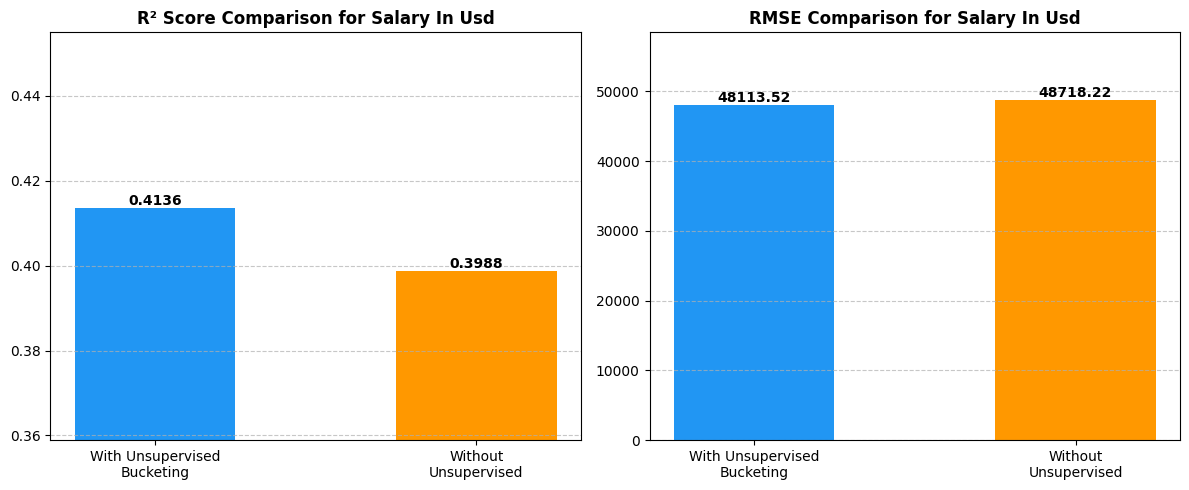


Creating prediction comparison visualization...

Comparing feature importance between models...


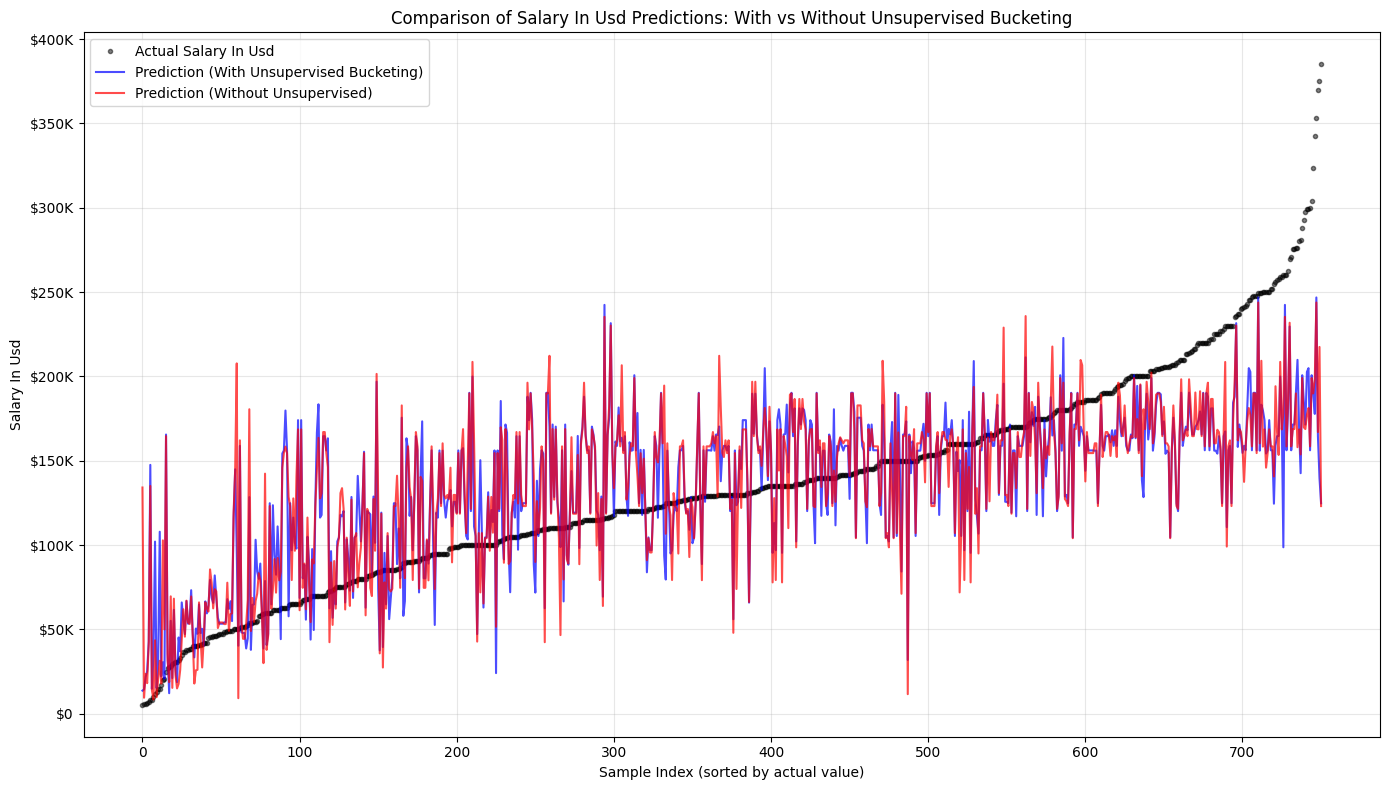

<Figure size 1200x800 with 0 Axes>

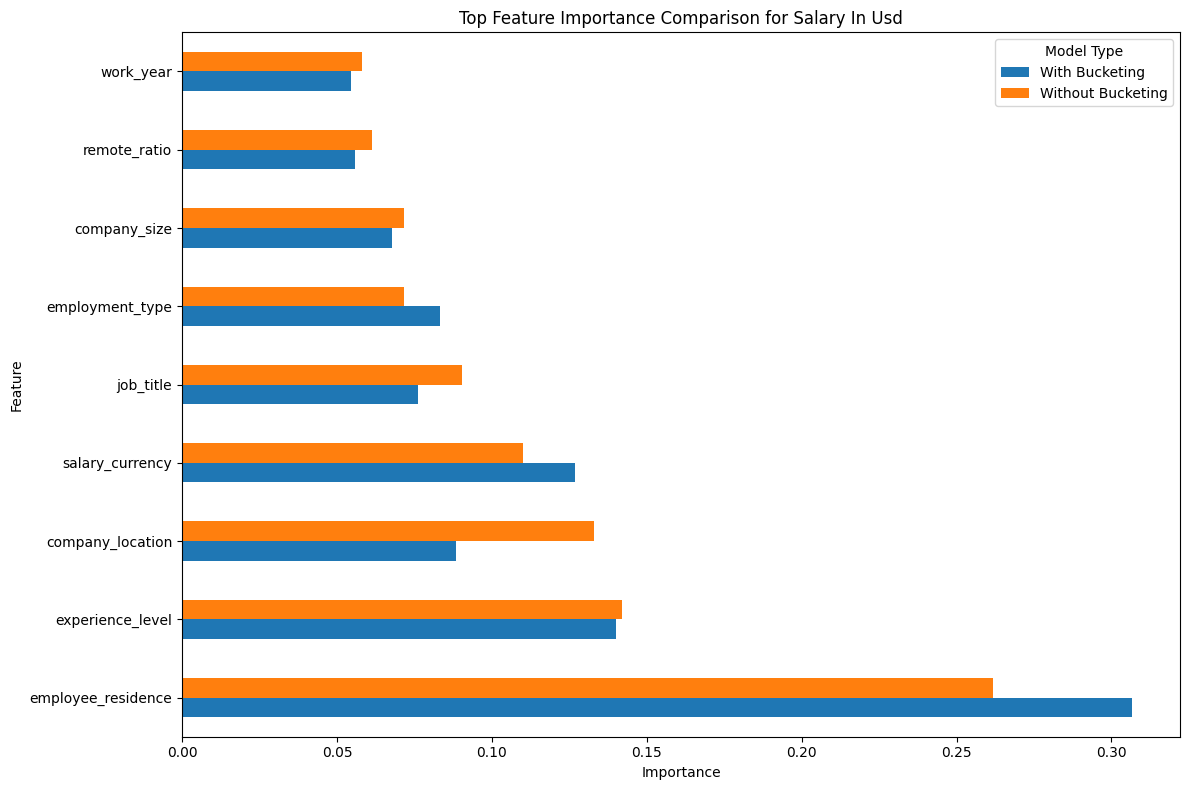


Quantile regression completed successfully!


In [52]:

# Example usage with the same parameters as the original code
path = "..\data\\ds_salaries.csv"
target_col = 'salary_in_usd'
drop_cols = ['salary']  # Columns to drop

results = train_quantile_regression(
    path=path,
    target_col=target_col,
    drop_cols=drop_cols,
    compare_models=True  # Compare models with and without unsupervised bucketing
)

Loading dataset from data\hospital data analysis.csv...
Using 'Cost' as target column
Training data: (787, 8), Test data: (197, 8)

=== Comparing Model with unsupervised bucketing vs Model without unsupervised ===

--- Running Model with unsupervised bucketing ---
Applying auto-bucketing...
Training quantile regression models...
Training model for 0.1 quantile...
Training model for 0.5 quantile...
Training model for 0.9 quantile...
Calculating performance metrics...
Model Performance:
R² Score: 0.8534
RMSE: 3057.42
Average 80% Prediction Interval Width: 11447.45
Extracting feature importance...

--- Running Model without unsupervised bucketing ---
Skipping bucketing...
Training quantile regression models...
Training model for 0.1 quantile...
Training model for 0.5 quantile...
Training model for 0.9 quantile...
Calculating performance metrics...
Model Performance:
R² Score: 0.9673
RMSE: 1444.02
Average 80% Prediction Interval Width: 12646.56
Extracting feature importance...

=== Perform

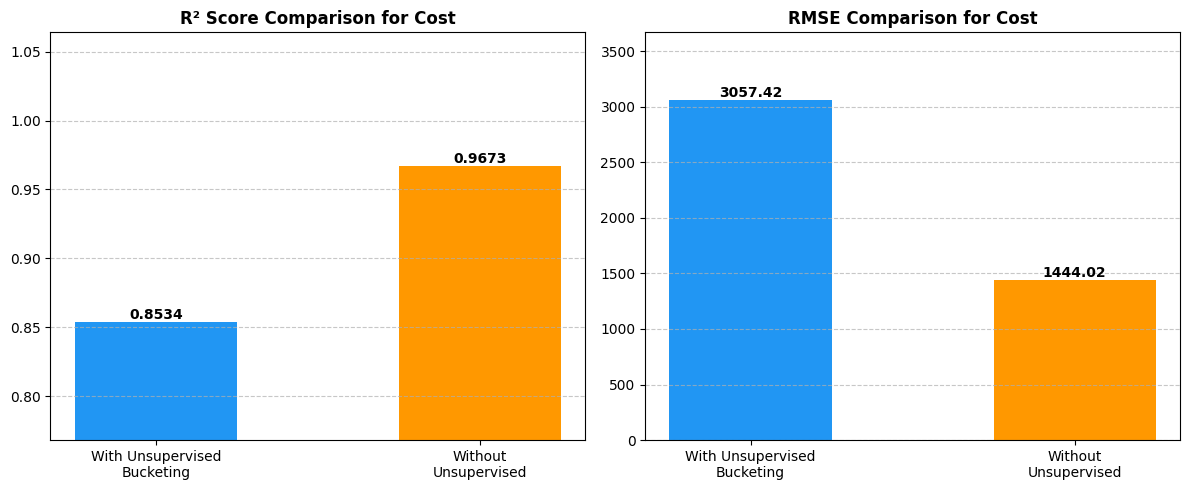


Creating prediction comparison visualization...

Comparing feature importance between models...


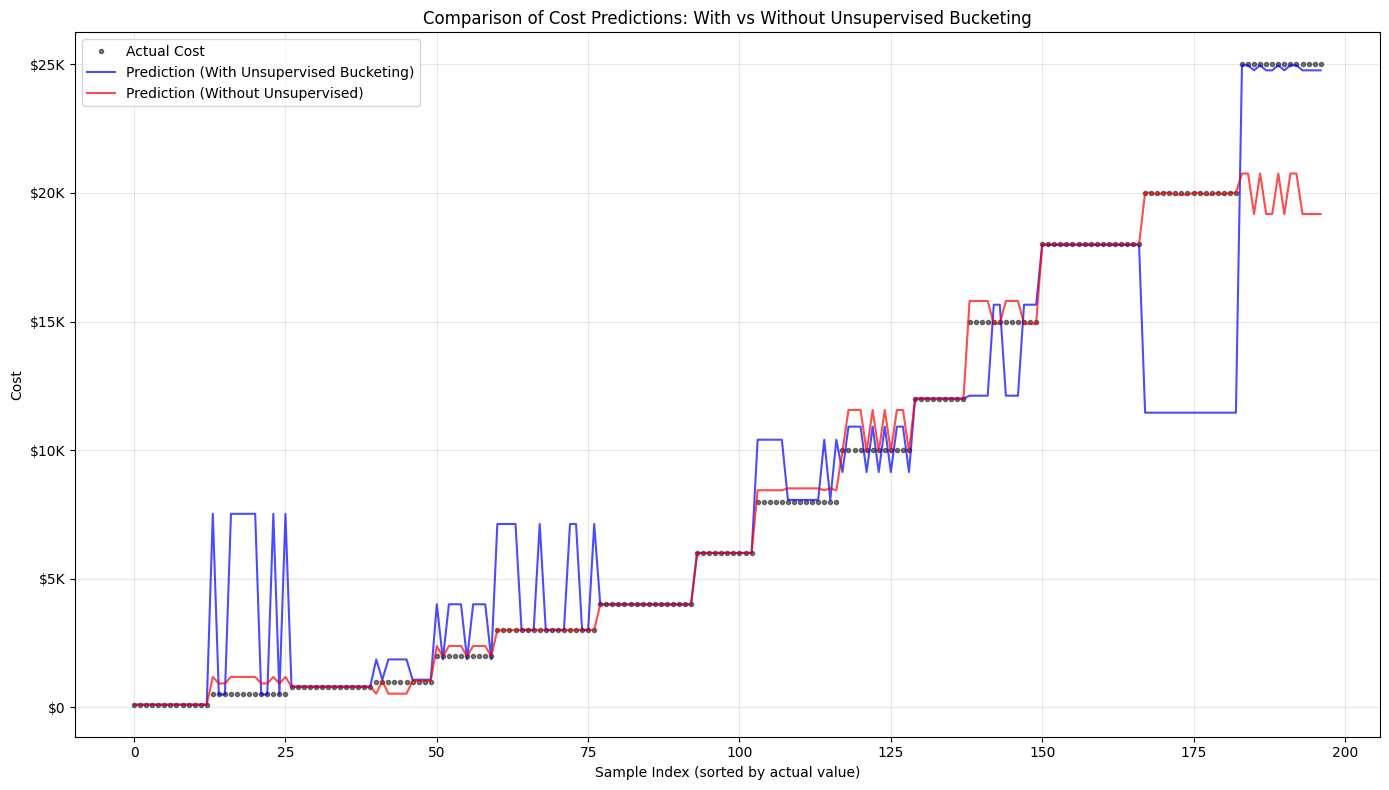

<Figure size 1200x800 with 0 Axes>

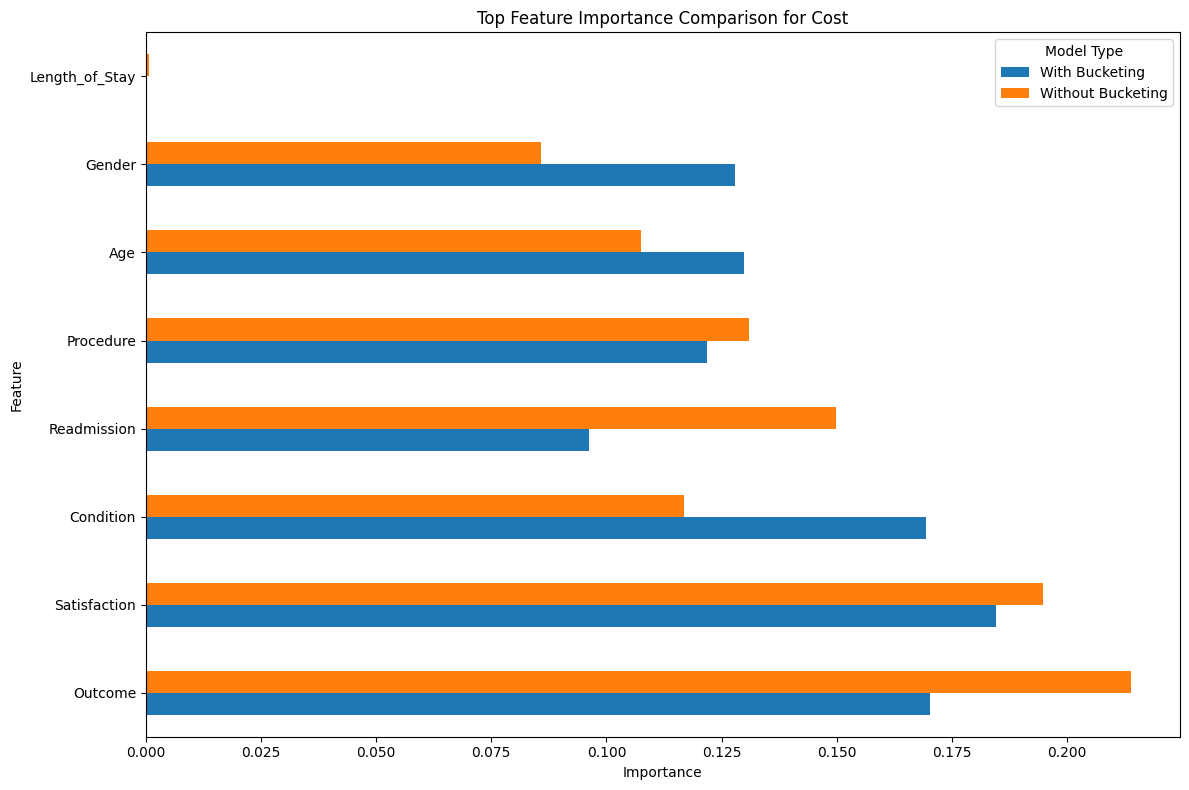


Quantile regression completed successfully!


In [53]:

# Example usage with the same parameters as the original code
path = "data\\hospital data analysis.csv"
target_col = 'Cost'
drop_cols = ['Patient_ID']  # Columns to drop

results = train_quantile_regression(
    path=path,
    target_col=target_col,
    drop_cols=drop_cols,
    n_buckets=5,
    compare_models=True  # Compare models with and without unsupervised bucketing
)

Loading dataset from data\House_Rent_Dataset.csv...
Using 'Rent' as target column
Training data: (3796, 11), Test data: (950, 11)

=== Comparing Model with unsupervised bucketing vs Model without unsupervised ===

--- Running Model with unsupervised bucketing ---
Applying auto-bucketing...
Training quantile regression models...
Training model for 0.1 quantile...
Training model for 0.5 quantile...
Training model for 0.9 quantile...
Calculating performance metrics...
Model Performance:
R² Score: 0.0809
RMSE: 60521.54
Average 80% Prediction Interval Width: 63827.30
Extracting feature importance...

--- Running Model without unsupervised bucketing ---
Skipping bucketing...
Training quantile regression models...
Training model for 0.1 quantile...
Training model for 0.5 quantile...
Training model for 0.9 quantile...
Calculating performance metrics...
Model Performance:
R² Score: 0.6407
RMSE: 37843.19
Average 80% Prediction Interval Width: 51760.86
Extracting feature importance...

=== Perfor

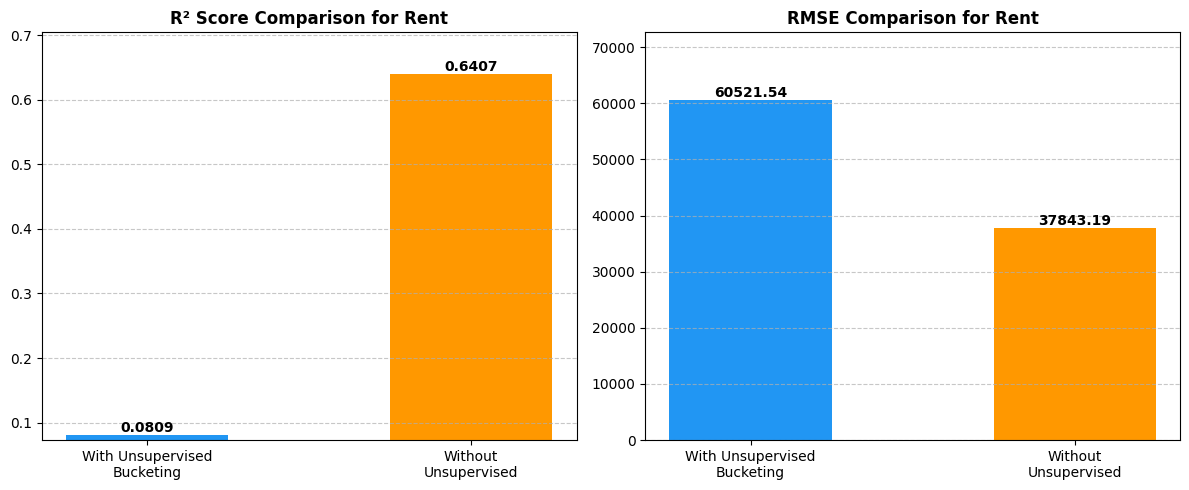


Creating prediction comparison visualization...

Comparing feature importance between models...


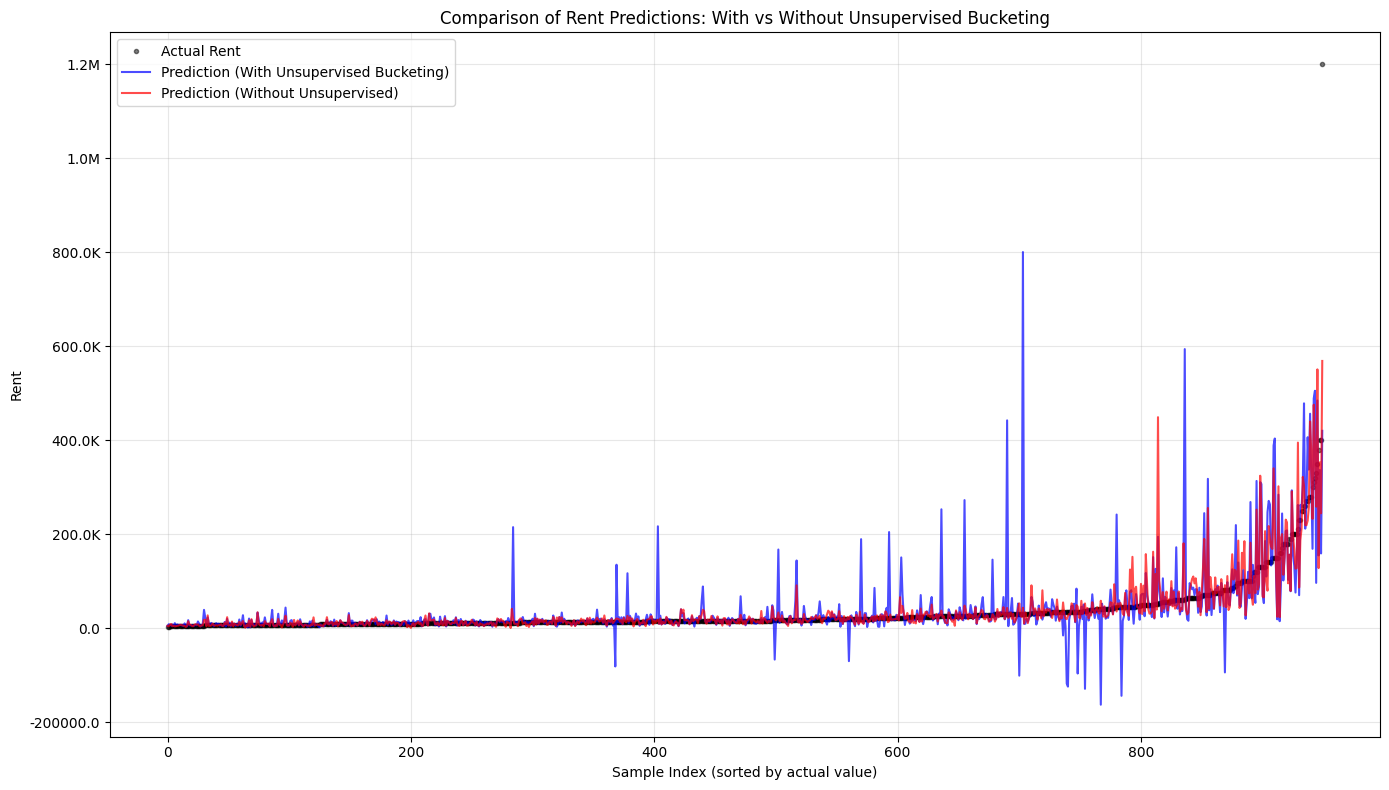

<Figure size 1200x800 with 0 Axes>

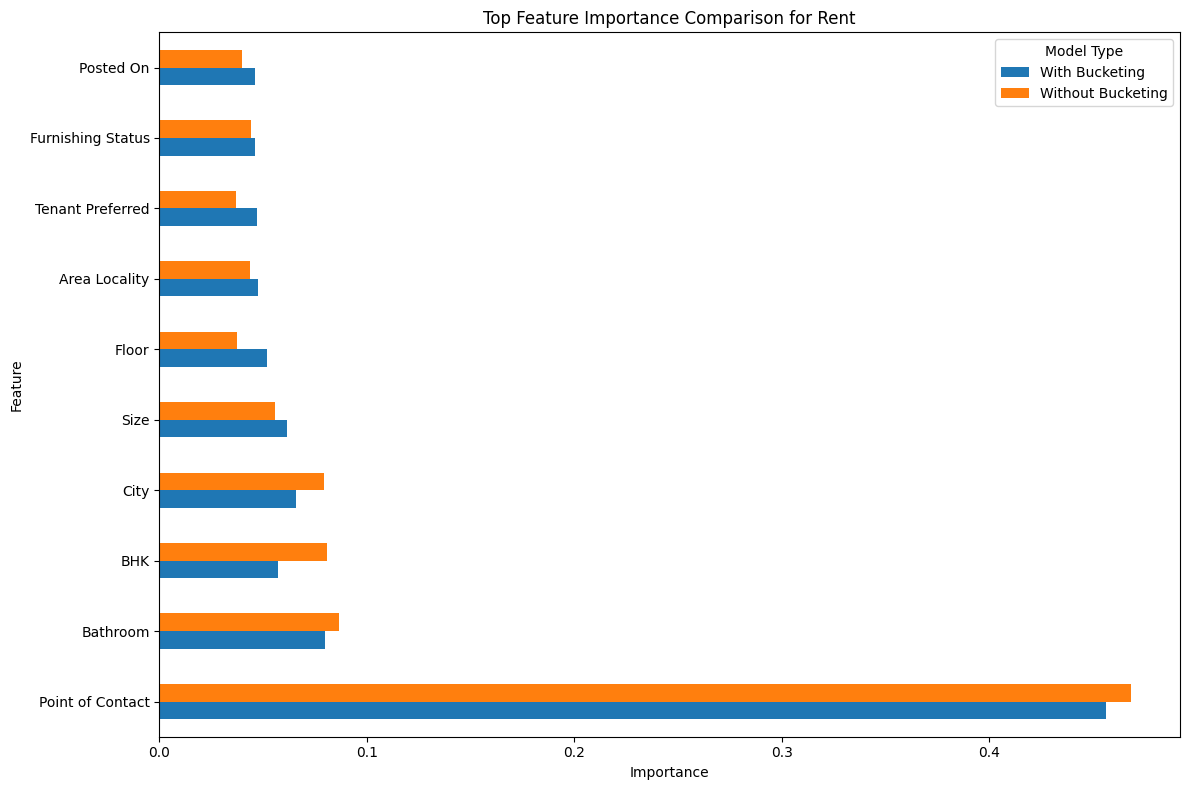


Quantile regression completed successfully!


In [54]:
# Example usage with the same parameters as the original code
path = "data\\House_Rent_Dataset.csv"
target_col = 'Rent'
drop_cols = []  # Columns to drop

results = train_quantile_regression(
    path=path,
    target_col=target_col,
    drop_cols=drop_cols,
    n_buckets=5,
    compare_models=True  # Compare models with and without unsupervised bucketing
)

Loading dataset from data\Sample-Superstore.csv...
Using 'Profit' as target column
Training data: (7995, 20), Test data: (1999, 20)

=== Comparing Model with unsupervised bucketing vs Model without unsupervised ===

--- Running Model with unsupervised bucketing ---
Applying auto-bucketing...
Training quantile regression models...
Training model for 0.1 quantile...
Training model for 0.5 quantile...
Training model for 0.9 quantile...
Calculating performance metrics...
Model Performance:
R² Score: 0.2473
RMSE: 191.04
Average 80% Prediction Interval Width: 89.88
Extracting feature importance...

--- Running Model without unsupervised bucketing ---
Skipping bucketing...
Training quantile regression models...
Training model for 0.1 quantile...
Training model for 0.5 quantile...
Training model for 0.9 quantile...
Calculating performance metrics...
Model Performance:
R² Score: 0.7547
RMSE: 109.06
Average 80% Prediction Interval Width: 63.89
Extracting feature importance...

=== Performance Co

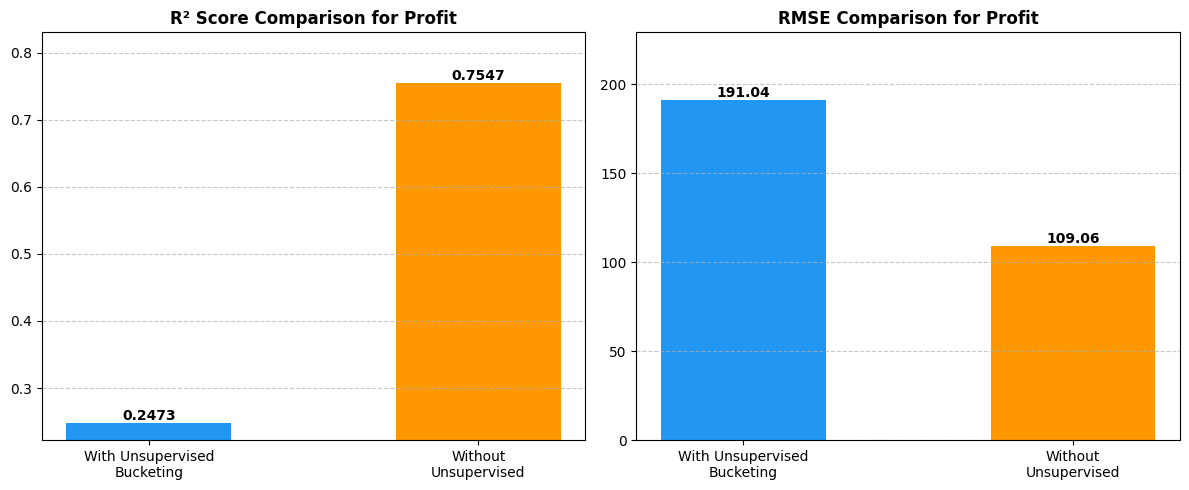


Creating prediction comparison visualization...

Comparing feature importance between models...


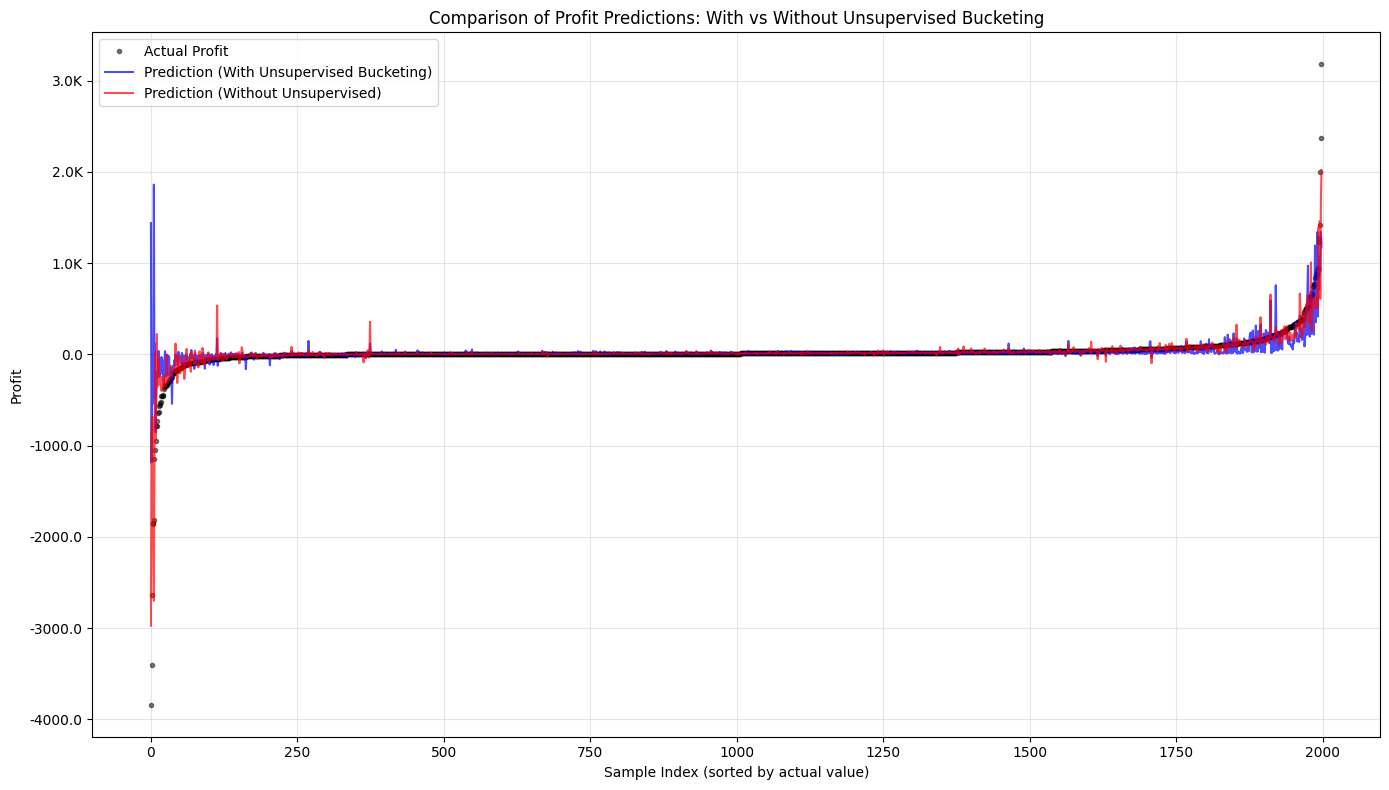

<Figure size 1200x800 with 0 Axes>

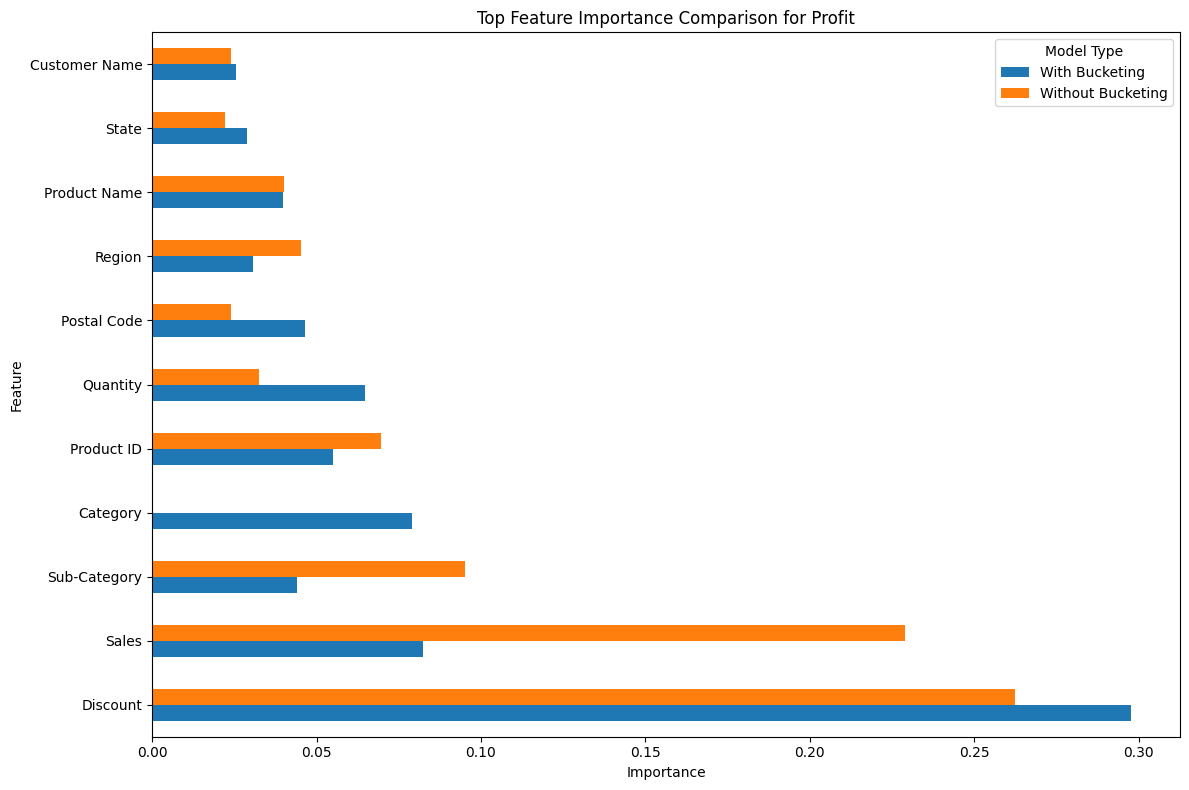


Quantile regression completed successfully!


In [55]:
# Example usage with the same parameters as the original code
path = "data\\Sample-Superstore.csv"
target_col = 'Profit'
drop_cols = []  # Columns to drop

results = train_quantile_regression(
    path=path,
    target_col=target_col,
    drop_cols=drop_cols,
    n_buckets=5,
    compare_models=True  # Compare models with and without unsupervised bucketing
)